# F1 Qualifying Position vs. Race Finish Position Performance Analysis (2021 - 2024 Season)

# Import necessary libraries

In [11]:
import pandas as pd
import numpy as np
import sqlite3
import os
import glob
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [12]:
csv_folder_path = 'F1dataset' 
database_path = 'f1_project.db'

con = sqlite3.connect(database_path)

csv_files = glob.glob(os.path.join(csv_folder_path, '*.csv'))

for file in csv_files:
    df = pd.read_csv(file)
    
    table_name = os.path.splitext(os.path.basename(file))[0]
    
    df.to_sql(table_name, con, if_exists='replace', index=False)
    
    print(f"Loaded {table_name} into the database.")

Loaded circuits into the database.
Loaded constructors into the database.
Loaded constructor_results into the database.
Loaded constructor_standings into the database.
Loaded drivers into the database.
Loaded driver_standings into the database.
Loaded lap_times into the database.
Loaded pit_stops into the database.
Loaded qualifying into the database.
Loaded races into the database.
Loaded results into the database.
Loaded seasons into the database.
Loaded sprint_results into the database.
Loaded status into the database.


# Building the Master F1 Analysis Dataset

In [13]:
create_tables_script = """
        DROP TABLE IF EXISTS master_analysis_data;
        DROP TABLE IF EXISTS master_finished_analysis_data;

        CREATE TABLE master_analysis_data AS
        SELECT  rc.year,
                rc.name AS raceName,
                dv.forename || ' ' || dv.surname AS driver,
                cs.name AS constructorName,
                re.grid AS grid,
                qf.position AS qualifyingPosition,
                re.positionOrder AS racePosition,
                re.laps AS laps,
                st.status AS status
        FROM races AS rc
        INNER JOIN results AS re ON rc.raceID = re.raceID
        INNER JOIN drivers AS dv ON re.driverID = dv.driverID
        INNER JOIN constructors AS cs ON re.constructorId = cs.constructorId
        INNER JOIN qualifying AS qf ON  rc.raceID = qf.raceID 
                AND re.driverID = qf.driverID
        INNER JOIN status AS st on re.statusID = st.statusID
        WHERE year >= 2021
                AND year <= 2024;

        CREATE TABLE master_finished_analysis_data AS
        SELECT *
        FROM master_analysis_data
        WHERE status = 'Finished'
"""

with sqlite3.connect("f1_project.db") as con:
        con.executescript(create_tables_script)


analysis_finished_query = """
    SELECT * 
    FROM master_finished_analysis_data
"""
with sqlite3.connect("f1_project.db") as con:
        analysis_finished_df = pd.read_sql_query(analysis_finished_query, con)


analysis_finished_df.head()

,year,raceName,driver,constructorName,grid,qualifyingPosition,racePosition,laps,status
0,2021,Emilia Romagna Grand Prix,Lewis Hamilton,Mercedes,1,1,2,63,Finished
1,2021,Emilia Romagna Grand Prix,Fernando Alonso,Alpine F1 Team,15,15,10,63,Finished
2,2021,Emilia Romagna Grand Prix,Kimi Räikkönen,Alfa Romeo,16,16,13,63,Finished
3,2021,Emilia Romagna Grand Prix,Sergio Pérez,Red Bull,2,2,11,63,Finished
4,2021,Emilia Romagna Grand Prix,Daniel Ricciardo,McLaren,6,6,6,63,Finished


# Creating visualizations

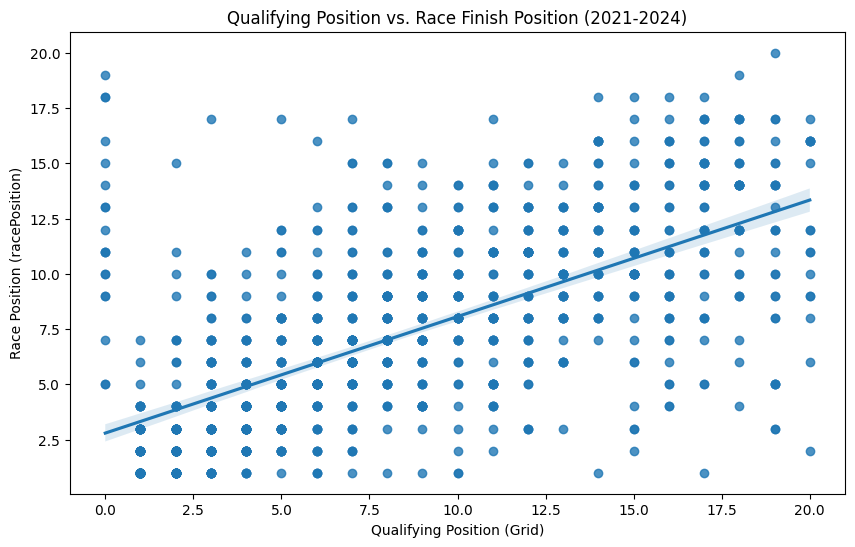

In [14]:
plt.figure(figsize=(10, 6))
sns.regplot(data=analysis_finished_df, x='grid', y='racePosition')
plt.title('Qualifying Position vs. Race Finish Position (2021-2024)')
plt.xlabel('Qualifying Position (Grid)')
plt.ylabel('Race Position (racePosition)')

plt.show()

The regression plot above visualizes the relationship between a driver's starting grid position and their final race position for the 2021-2024 F1 seasons.

The clear upward-sloping trendline shows a strong positive correlation between the two variables. This indicates that, on average, a driver's starting position is a strong predictor of their finishing position.

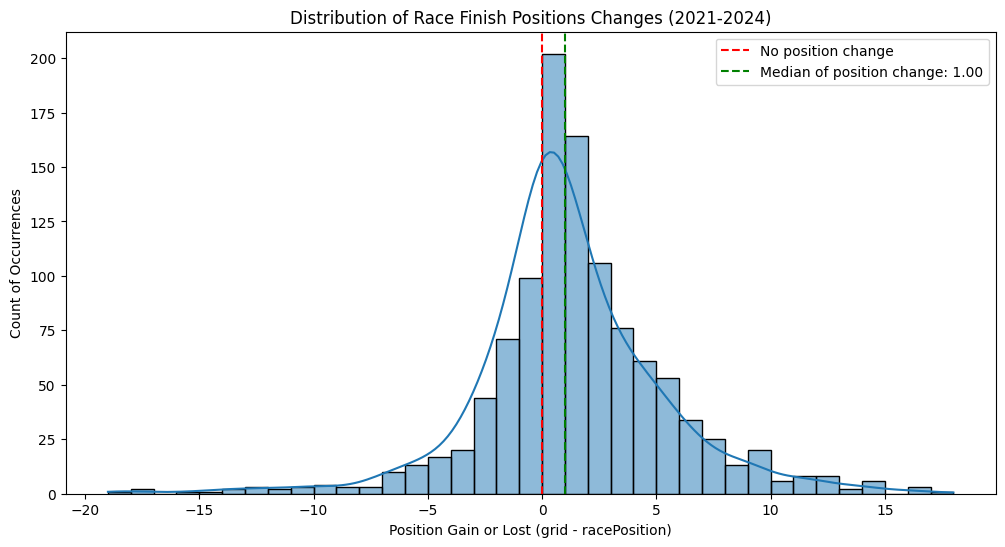

In [15]:
position_change_query = """
    SELECT (grid - racePosition) AS position_change
    FROM master_finished_analysis_data
"""

with sqlite3.connect("f1_project.db") as con:
    position_change_df = pd.read_sql_query(position_change_query, con)

median_change = position_change_df['position_change'].median()
plt.figure(figsize=(12, 6))
sns.histplot(position_change_df, x = 'position_change', binwidth = 1, kde=True)
plt.axvline(0, color='red', linestyle='--', label='No position change')
plt.axvline(median_change, color='green', linestyle='--', label=f'Median of position change: {median_change:.2f}')
plt.legend()

plt.title('Distribution of Race Finish Positions Changes (2021-2024)')
plt.xlabel('Position Gain or Lost (grid - racePosition)')
plt.ylabel('Count of Occurrences')

plt.show()

The histogram central peak is at the range [0,1], indicating that most common outcome is drivers finishing their race in or very near their starting grid position.

Also, from the distribution, we can see that large position changes (gain or lose position over 10), are rarely happened.

The median of the distribution is 1.0. A positive median suggests that drivers are more likely to gain position rather than lose position.

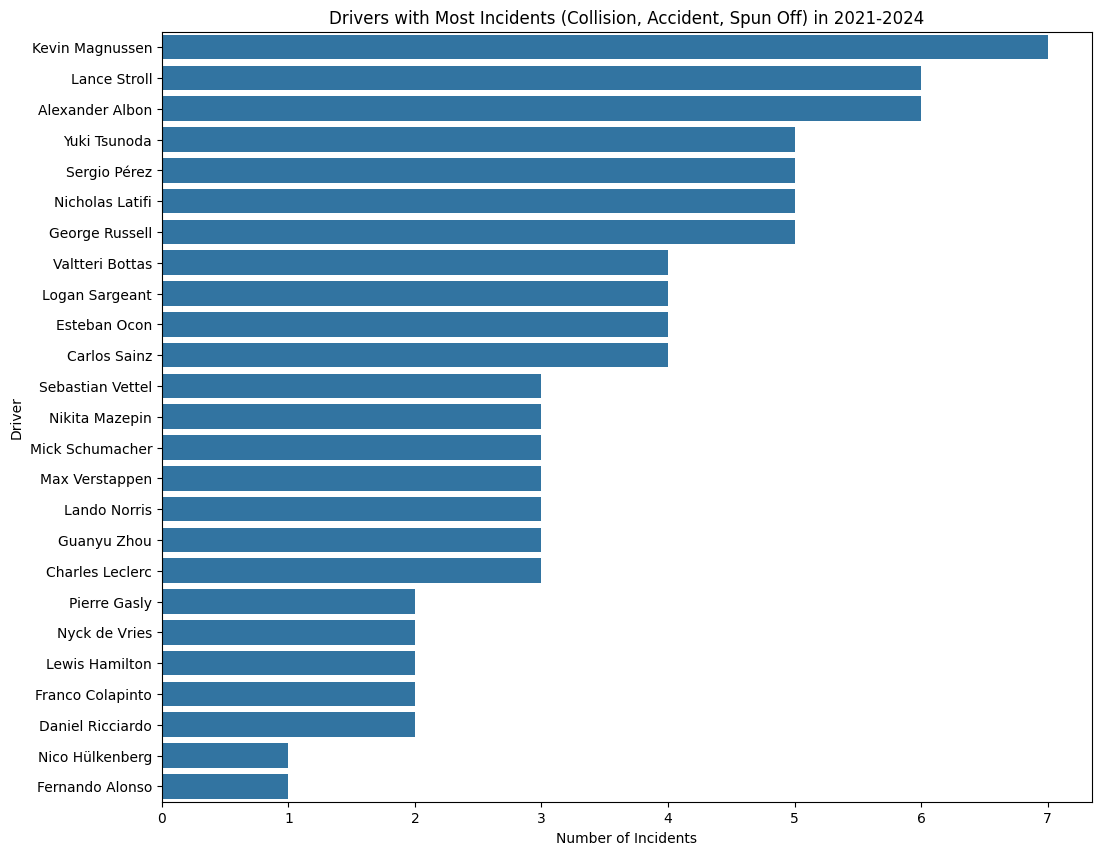

In [16]:
driver_incident_counts_query = """
    SELECT driver, count(1) AS number_of_incidents
    FROM  master_analysis_data
    WHERE status IN ('Collision',
                    'Accident',
                    'Spun Off',
                    'Damage',
                    'Puncture',
                    'Front wing',
                    'Rear wing')
    GROUP BY driver
    ORDER BY number_of_incidents DESC
"""

with sqlite3.connect("f1_project.db") as con:
    driver_incident_counts_df = pd.read_sql_query(driver_incident_counts_query, con)


plt.figure(figsize=(12, 10))
sns.barplot(data=driver_incident_counts_df, x='number_of_incidents', y='driver', orient='h')

plt.title('Drivers with Most Incidents (Collision, Accident, Spun Off) in 2021-2024')
plt.xlabel('Number of Incidents')
plt.ylabel('Driver')

plt.show()

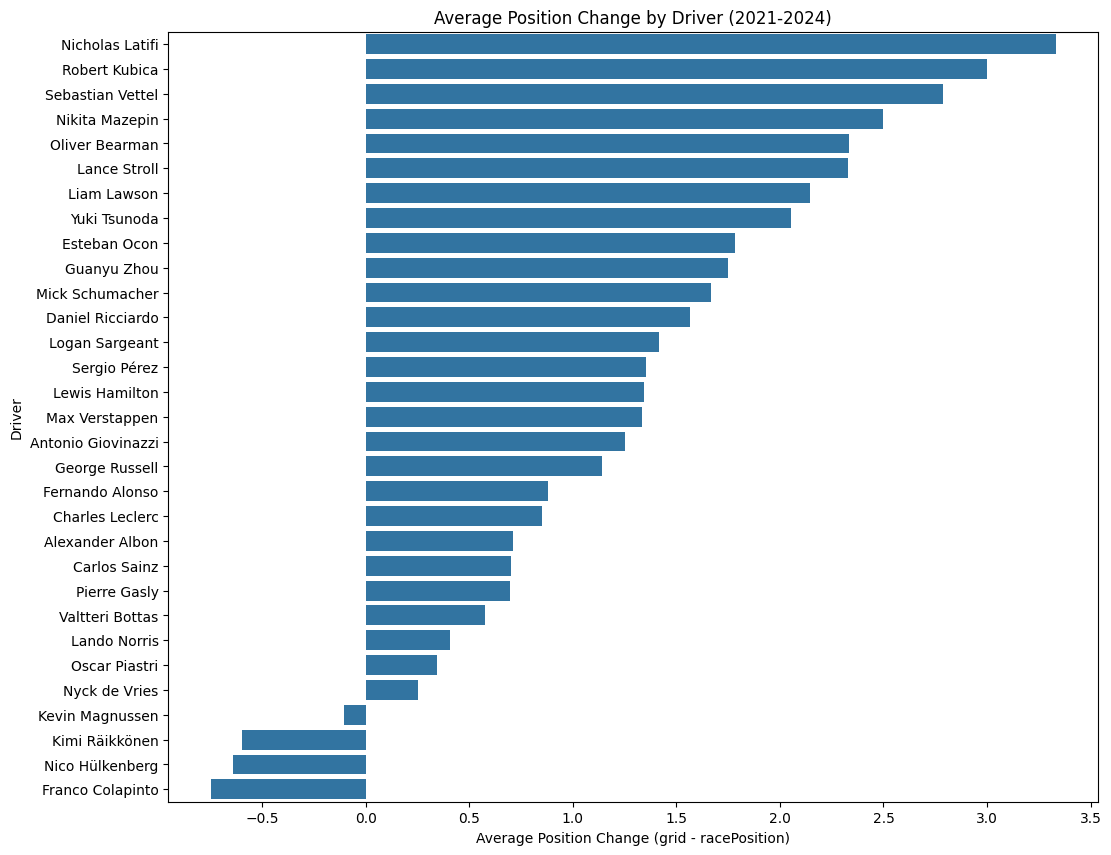

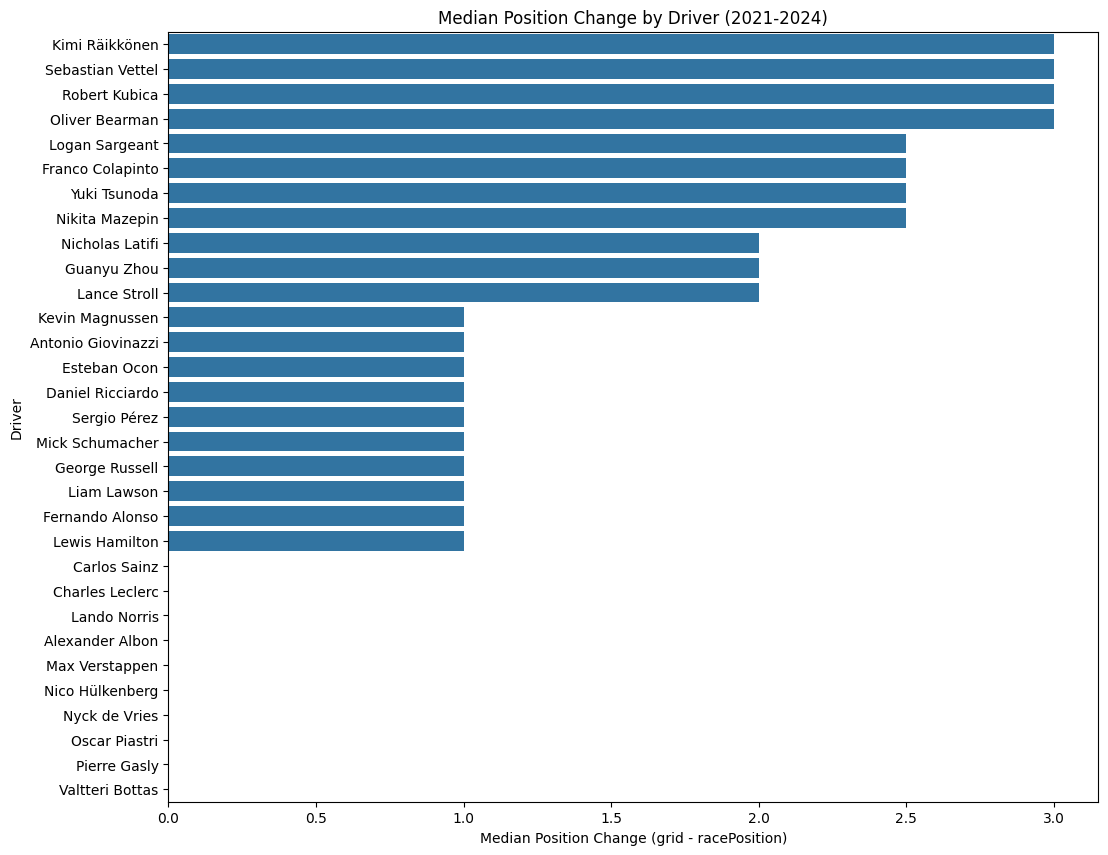

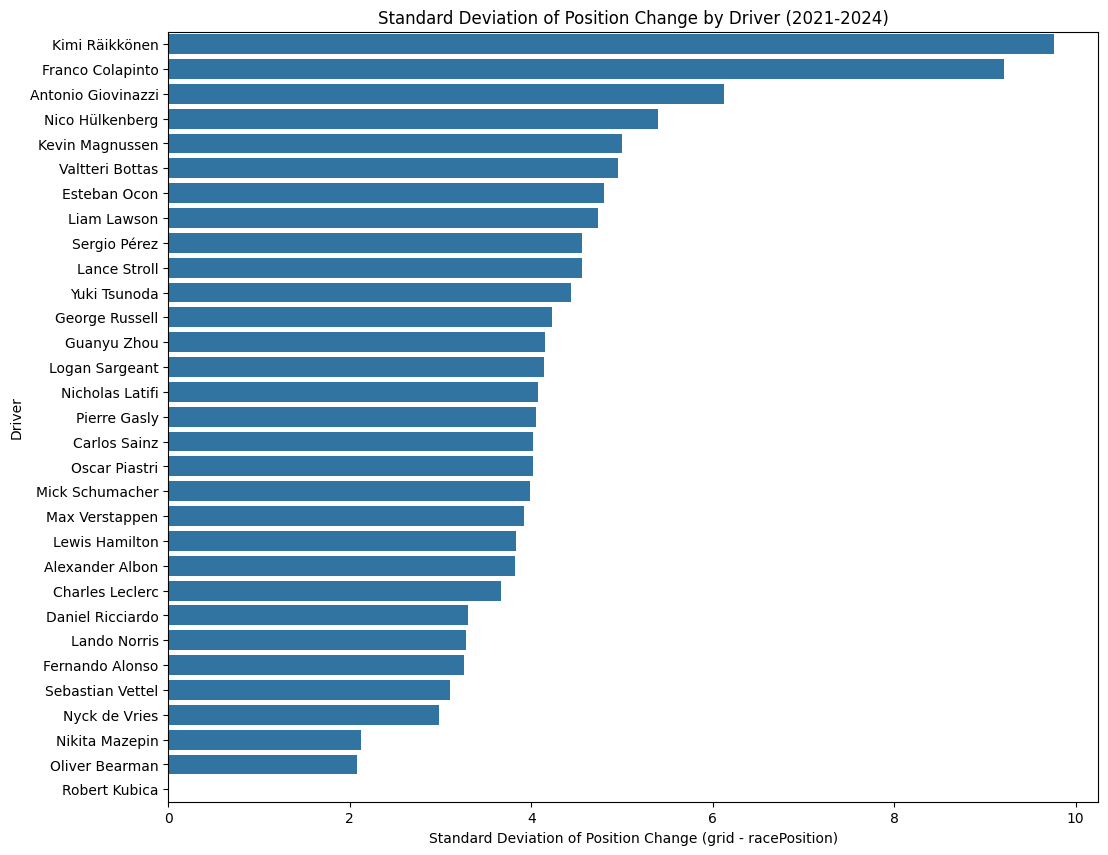

In [17]:
avg_driver_performance_query = """
    SELECT avg(grid - racePosition) AS avg_position_change,
        driver
    FROM master_finished_analysis_data
    GROUP BY driver
    ORDER BY avg_position_change DESC
"""

with sqlite3.connect("f1_project.db") as con:
    avg_driver_performance_df = pd.read_sql_query(avg_driver_performance_query, con)

plt.figure(figsize=(12, 10))
sns.barplot(data=avg_driver_performance_df, x='avg_position_change', y='driver', orient='h')

plt.title('Average Position Change by Driver (2021-2024)')
plt.xlabel('Average Position Change (grid - racePosition)')
plt.ylabel('Driver')

plt.show()

all_driver_performance_query = """
    SELECT (grid - racePosition) AS position_change,
        driver
    FROM master_finished_analysis_data
"""

with sqlite3.connect("f1_project.db") as con:
    all_driver_performance_df = pd.read_sql_query(all_driver_performance_query, con)

med_driver_performance_df = all_driver_performance_df.groupby('driver')['position_change'].median().reset_index()
med_driver_performance_df = med_driver_performance_df.sort_values(by='position_change', ascending=False)
med_driver_performance_df = med_driver_performance_df.rename(columns={'position_change': 'med_position_change'})

plt.figure(figsize=(12, 10))
sns.barplot(data=med_driver_performance_df, x='med_position_change', y='driver', orient='h')

plt.title('Median Position Change by Driver (2021-2024)')
plt.xlabel('Median Position Change (grid - racePosition)')
plt.ylabel('Driver')

plt.show()

sd_driver_performance_df = all_driver_performance_df.groupby('driver')['position_change'].std().reset_index()
sd_driver_performance_df = sd_driver_performance_df.sort_values(by='position_change', ascending=False)
sd_driver_performance_df = sd_driver_performance_df.rename(columns={'position_change': 'sd_position_change'})

plt.figure(figsize=(12, 10))
sns.barplot(data=sd_driver_performance_df, x='sd_position_change', y='driver', orient='h')

plt.title('Standard Deviation of Position Change by Driver (2021-2024)')
plt.xlabel('Standard Deviation of Position Change (grid - racePosition)')
plt.ylabel('Driver')

plt.show()

# The Story Behind Driver Performance

After creating a master dataset of all finished race results from 2021-2024, I wanted to understand which drivers consistently outperformed their qualifying position. To get a complete picture, I analyzed three key metrics for each driver:

**Average:** Their overall position change.

**Median:** Their typical race-day position change.

**Standard Deviation:** Their level of consistency or volatility.

I found that on the Average plot, Kimi Räikkönen shows a negative position change, suggesting that he typically finished worse than he started.

However, the Median plot tells a completely different story. His median position change was +3.0, meaning that in a typical (more than 50%) race, he actually gained three positions.

The Standard Deviation plot solves this confusion. Räikkönen has the highest SD of any driver, indicating his results were extremely inconsistent.

Thus, Räikkönen's several huge position losses (extreme outliers) dragged his overall average into the negative, even though his typical performance was strong. 

---

By combining all three metrics, like Räikkönen's story, we can identify distinct "driver profiles" on the grid:

**The Race-Day Overperformers (High Median):** Drivers like Kimi Räikkönen (+3.0), Sebastian Vettel (+3.0), and Robert Kubica (+3.0) stand out. Despite where they qualified, their median race result was three positions higher, showing a clear tendency to outperform on Sunday. This might because both Räikkönen and Vettel were F1 champions. And they drive for midfield teams in the final years before their retirement. These less competitive cars often resulted in lower grid positions, but their race-day experience allowed them to consistently gain positions.

**The Unpredictables (High SD):** Drivers with the highest SD, like Kimi Räikkönen and Antonio Giovinazzi, are the "chaos" drivers. Their races were highly variable, with both significant gains and significant losses. These drivers are more in midfield teams，they were more likely to be involved in incidents or attempt high-risk, alternative strategies, leading to this unpredictable pattern in their results.

**The Consistent Performers (Low SD):** Drivers like Nikita Mazepin and Oliver Bearman show the lowest SD. This means their finishing position was much more predictable relative to their start (this doesn't mean good performance, just consistent). This predictability is often seen in drivers in the least competitive cars. For example, Mazepin, driving for the last-place Haas team in 2021, consistently qualified and finished at the back, leading to very low variation.

**The "Top Tier" (Median near 0.0):** Interestingly, dominant drivers like Max Verstappen and Lewis Hamilton have a median position change very close to 0.0. This isn't because they perform bad. Rather, it's because they consistently qualify at the front (P1, P2, P3) and finish in those same top positions, even pole to win. This leading to a "typical" change of zero.

Next, I want to move to analysis the circuit. Just as drivers have unique profiles, so do circuits. To understand this, I'm going to analyze the data by raceName using four plots: Total Incidents, Average Position Change, Median Position Change, and Standard Deviation (SD).

Hypothesis: Circuits with more incidents would be more unpredictable (higher Standard Deviation) ,also lead to more position change.

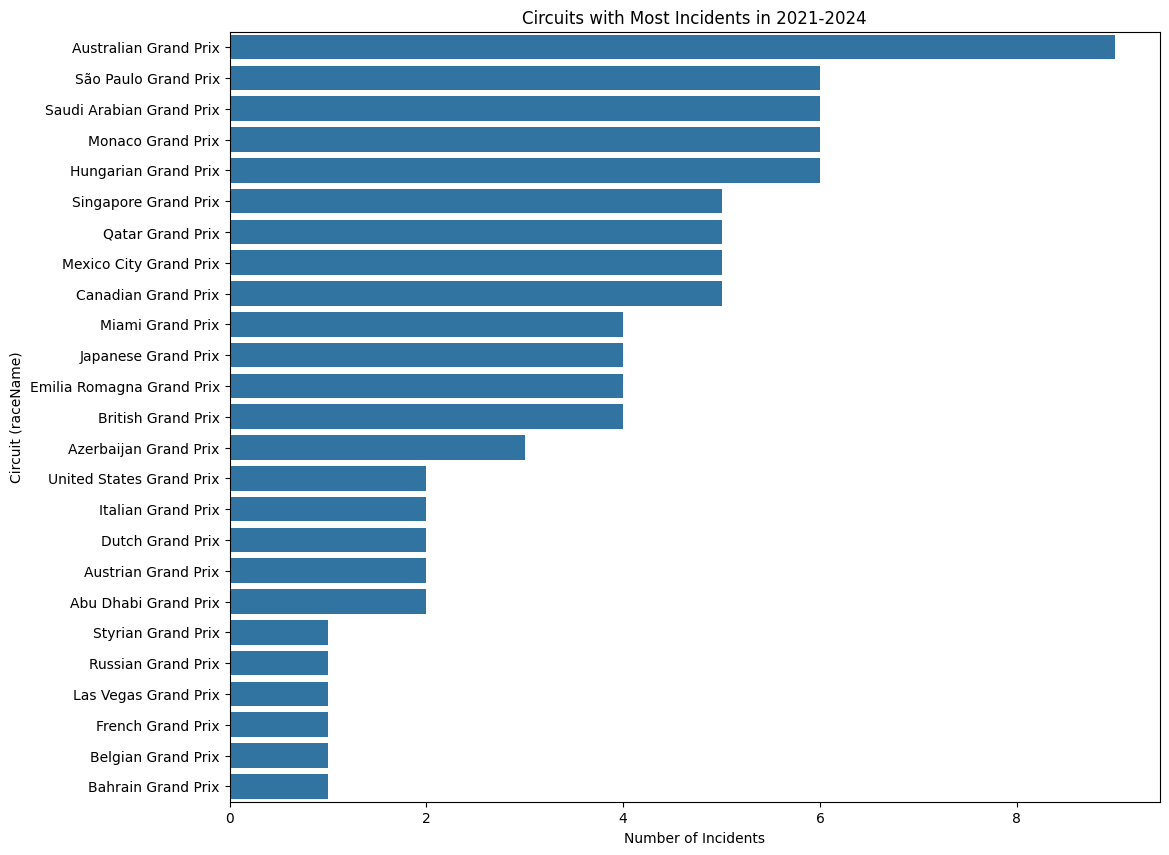

In [18]:
circuit_incidents_count_query = """
    SELECT raceName, count(1) AS number_of_incidents
    FROM  master_analysis_data
    WHERE status IN ('Collision',
                    'Accident',
                    'Spun Off',
                    'Damage',
                    'Puncture',
                    'Front wing',
                    'Rear wing')
    GROUP BY raceName
    ORDER BY number_of_incidents DESC
"""

with sqlite3.connect("f1_project.db") as con:
    circuit_incidents_count_df = pd.read_sql_query(circuit_incidents_count_query, con)


plt.figure(figsize=(12, 10))
sns.barplot(data=circuit_incidents_count_df, x='number_of_incidents', y='raceName', orient='h')

plt.title('Circuits with Most Incidents in 2021-2024')
plt.xlabel('Number of Incidents')
plt.ylabel('Circuit (raceName)')

plt.show()

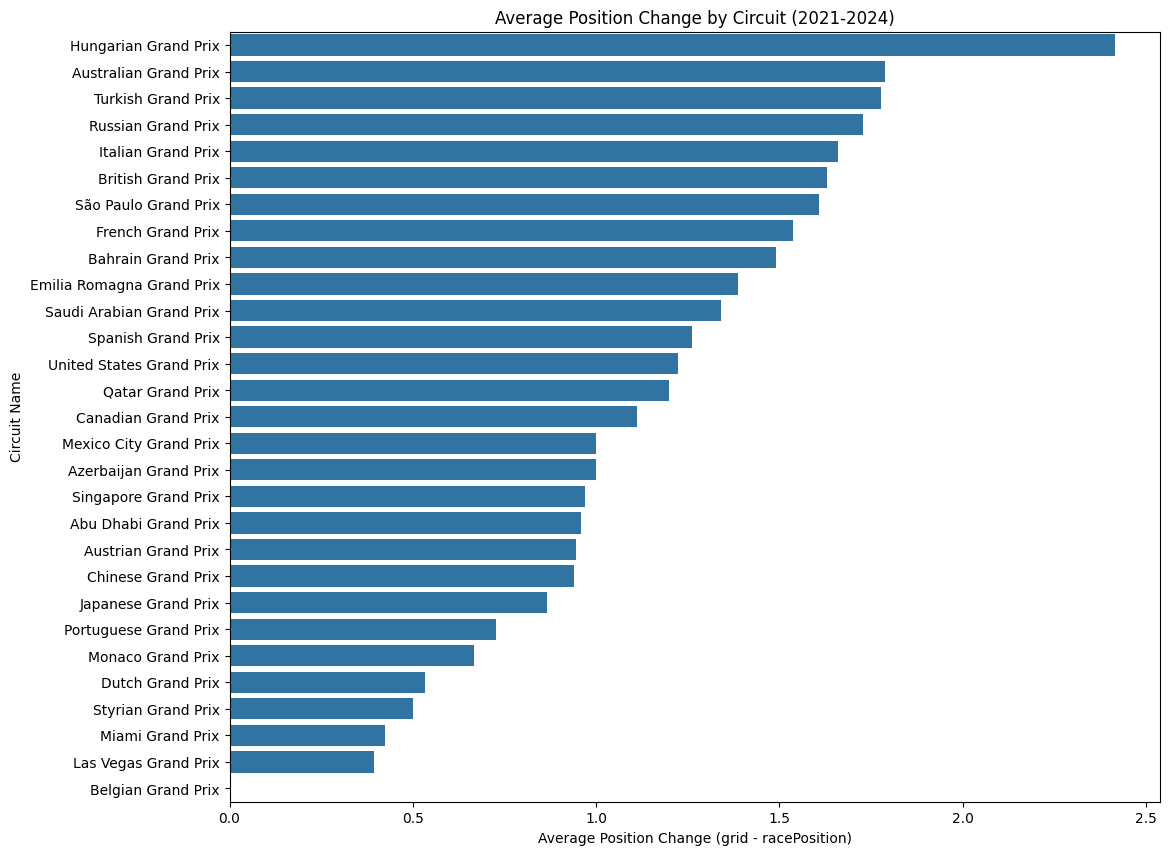

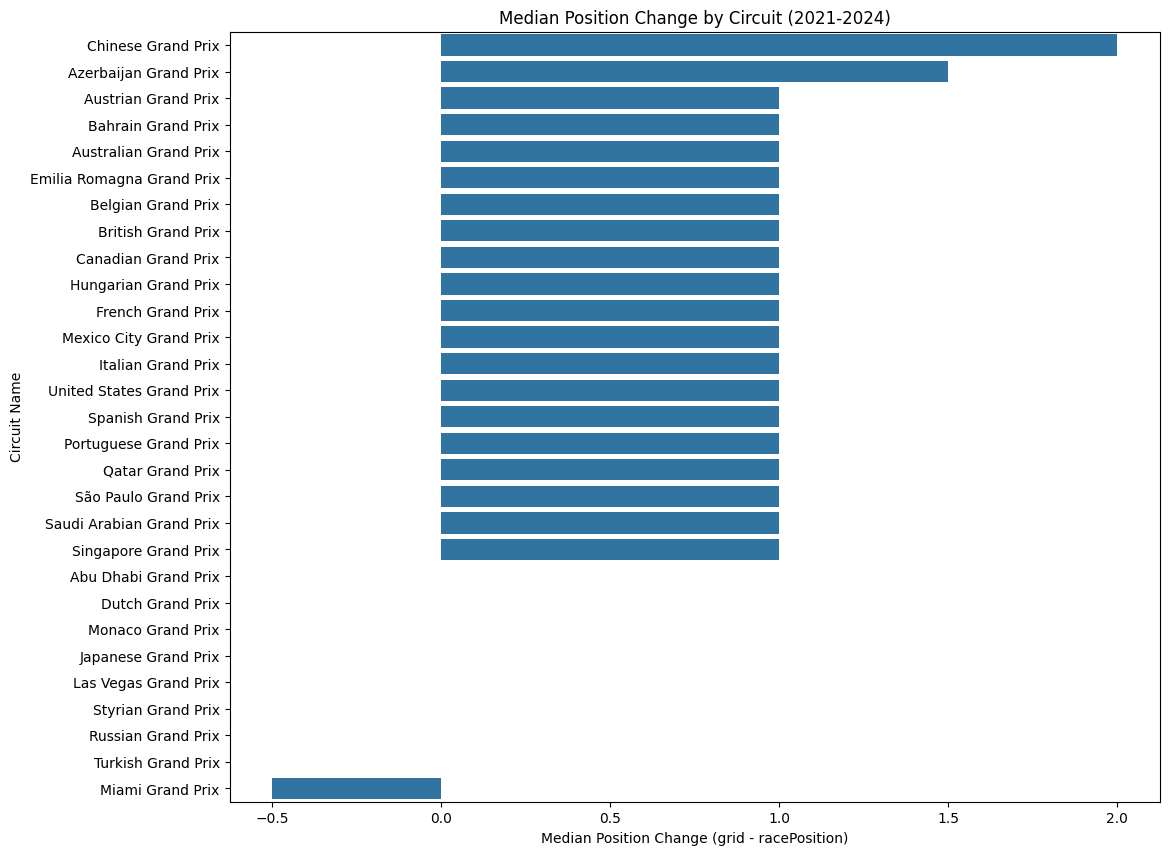

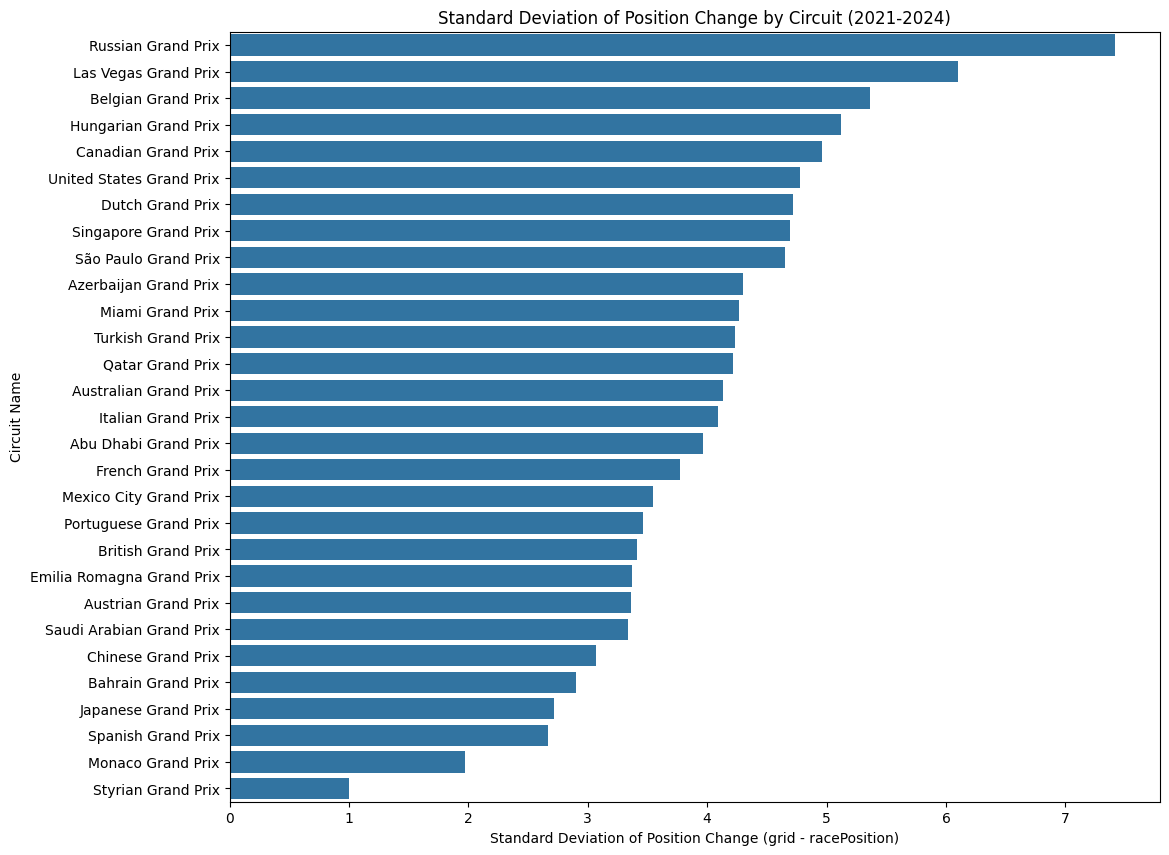

In [19]:
circuit_get_positions_query = """
    SELECT raceName, avg(grid - racePosition) AS position_change
    FROM master_finished_analysis_data
    GROUP BY raceName
    ORDER BY position_change DESC
"""

with sqlite3.connect("f1_project.db") as con:
    circuit_get_positions_df = pd.read_sql_query(circuit_get_positions_query, con)


plt.figure(figsize=(12, 10))
sns.barplot(data=circuit_get_positions_df, x='position_change', y='raceName', orient='h')

plt.title('Average Position Change by Circuit (2021-2024)')
plt.xlabel('Average Position Change (grid - racePosition)')
plt.ylabel('Circuit Name')

plt.show()

all_circuit_get_positions_query = """
    SELECT (grid - racePosition) AS position_change,
        raceName
    FROM master_finished_analysis_data
"""

with sqlite3.connect("f1_project.db") as con:
    all_circuit_get_positions_df = pd.read_sql_query(all_circuit_get_positions_query, con)

med_circuit_get_positions_df = all_circuit_get_positions_df.groupby('raceName')['position_change'].median().reset_index()
med_circuit_get_positions_df = med_circuit_get_positions_df.sort_values(by='position_change', ascending=False)
med_circuit_get_positions_df = med_circuit_get_positions_df.rename(columns={'position_change': 'med_position_change'})

plt.figure(figsize=(12, 10))
sns.barplot(data=med_circuit_get_positions_df, x='med_position_change', y='raceName', orient='h')
plt.title('Median Position Change by Circuit (2021-2024)')
plt.xlabel('Median Position Change (grid - racePosition)')
plt.ylabel('Circuit Name')  
plt.show()

sd_circuit_get_positions_df = all_circuit_get_positions_df.groupby('raceName')['position_change'].std().reset_index()
sd_circuit_get_positions_df = sd_circuit_get_positions_df.sort_values(by='position_change', ascending=False)
sd_circuit_get_positions_df = sd_circuit_get_positions_df.rename(columns={'position_change': 'sd_position_change'})

plt.figure(figsize=(12, 10))
sns.barplot(data=sd_circuit_get_positions_df, x='sd_position_change', y='raceName', orient='h')
plt.title('Standard Deviation of Position Change by Circuit (2021-2024)')
plt.xlabel('Standard Deviation of Position Change (grid - racePosition)')
plt.ylabel('Circuit Name')
plt.show()

# The Story of Circuit Personalities

My hypothesis is: Circuits with more incidents would be more unpredictable (higher Standard Deviation) ,also lead to more position change.

However, the data contradicts my hypothesis.

- The Russian Grand Prix has one of the lowest incident counts but has the highest SD (most unpredictable).

- Monaco has one of the highest incident counts but has one of the lowest SDs (most predictable).

- The Australian Grand Prix is #1 for incidents but is only average in terms of SD.

**Revised Conclusion:** Position changes aren't just about incidents. Factors like track layout (long straights and DRS zones like in Russia or Las Vegas, which are also high-SD) or weather (a common factor at Belgium, also high-SD) may also could lead to position changes.

---

**The Monaco vs. Singapore Paradox**

The data for Monaco and Singapore perfectly illustrates the difference between "incidents" and "unpredictability."

Both are tight, low-speed street circuits.

Both Monaco and Singapore are in the Top 6 for incidents, confirming they are chaotic tracks.

Despite the high number of incidents, Monaco has one of the lowest SDs. This means that even though incidents happen, they don't significantly change the race order. Singapore, however, has a much higher SD, indicating that the incidents there do effectively shuffle the pack, likely due to safety car timing or track-blocking crashes.

---

**From Median Position Change Plot**

The Median Position Change plot is perhaps the most useful, as it shows the typical outcome for a driver, ignoring single outlier races.

The Chinese GP and Azerbaijan GP are the clear "overperformance" tracks, with a median gain of +2.0 and +1.5 positions, respectively.

At the other end, tracks like Monaco, Abu Dhabi, and Dutch GP all have a median position change of 0.0. This statistically confirms drivers are more likely to finish exactly where they started on these tracks.

The Miami GP is the only track with a negative median, suggesting drivers typically finish worse than they started there.

This will lead to three new questions:

1. How does a circuit's layout affect position changes?

2. How did weather condition influence the position change.

3. How does the impact of a factor, like incidents, on position change or SD differ between circuits? (e.g., why do high incidents in Monaco lead to low SD, while in Singapore they lead to high SD?)

Generally, circuits with long straights and DRS zones are considered high-speed (like Las Vegas), while those defined by many corners are considered low-speed (like Monaco).

Therefore, I will classify circuit layout by its overall speed (High, Medium, or Low).

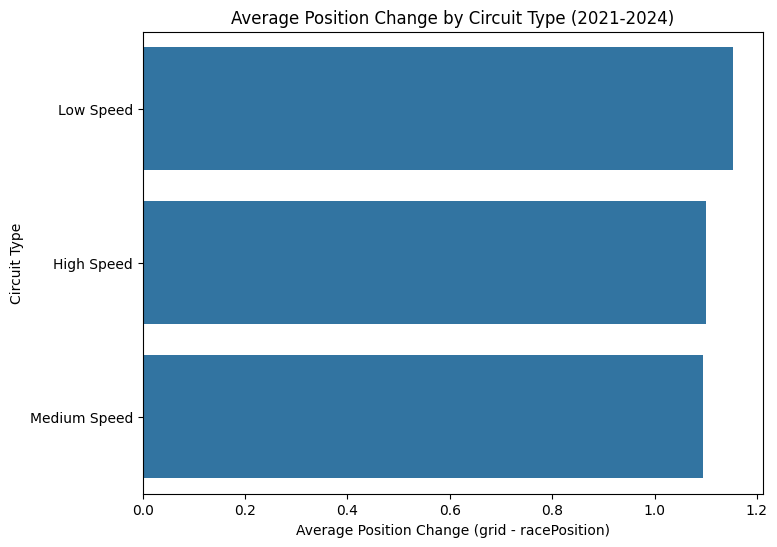

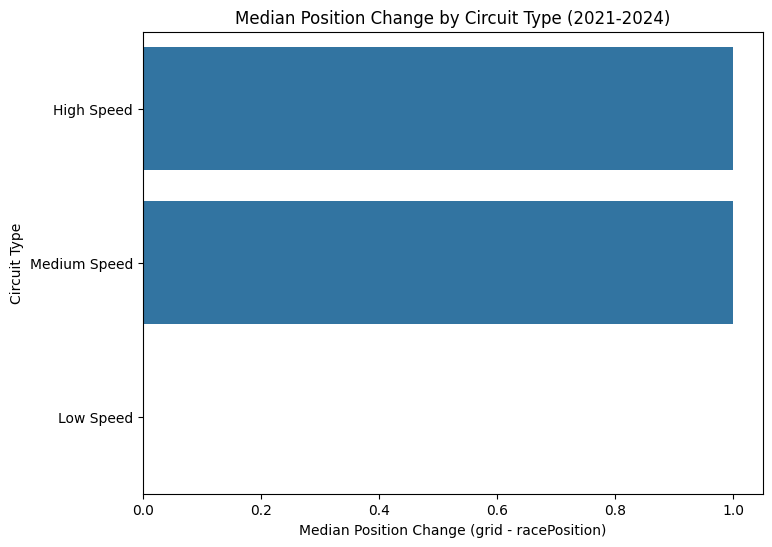

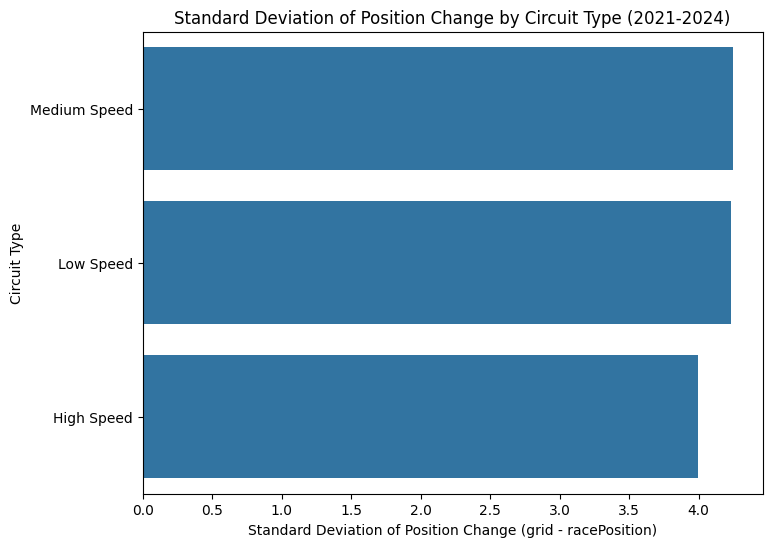

In [20]:
all_circuit_type_performance_query = """
DROP TABLE IF EXISTS all_circuit_type_performance;

CREATE TABLE all_circuit_type_performance AS
SELECT 
    CASE raceName
        WHEN 'Australian Grand Prix' THEN 'High Speed'
        WHEN 'Italian Grand Prix' THEN 'High Speed'
        WHEN 'Styrian Grand Prix' THEN 'High Speed'
        WHEN 'Japanese Grand Prix' THEN 'High Speed'
        WHEN 'Saudi Arabian Grand Prix' THEN 'High Speed'
        WHEN 'British Grand Prix' THEN 'High Speed'
        WHEN 'Austrian Grand Prix' THEN 'High Speed'
        WHEN 'Belgian Grand Prix' THEN 'High Speed'

        WHEN 'Bahrain Grand Prix' THEN 'Medium Speed'
        WHEN 'Chinese Grand Prix' THEN 'Medium Speed'
        WHEN 'Emilia Romagna Grand Prix' THEN 'Medium Speed'
        WHEN 'Qatar Grand Prix' THEN 'Medium Speed'
        WHEN 'United States Grand Prix' THEN 'Medium Speed'
        WHEN 'Azerbaijan Grand Prix' THEN 'Medium Speed'
        WHEN 'Canadian Grand Prix' THEN 'Medium Speed'
        WHEN 'Miami Grand Prix' THEN 'Medium Speed'
        WHEN 'Portuguese Grand Prix' THEN 'Medium Speed'
        WHEN 'Las Vegas Grand Prix' THEN 'Medium Speed'
        WHEN 'French Grand Prix' THEN 'Medium Speed'
        WHEN 'Spanish Grand Prix' THEN 'Medium Speed'
        WHEN 'Turkish Grand Prix' THEN 'Medium Speed'
        WHEN 'Russian Grand Prix' THEN 'Medium Speed'

        WHEN 'Abu Dhabi Grand Prix' THEN 'Low Speed'
        WHEN 'Monaco Grand Prix' THEN 'Low Speed'
        WHEN 'São Paulo Grand Prix' THEN 'Low Speed'
        WHEN 'Hungarian Grand Prix' THEN 'Low Speed'
        WHEN 'Mexico City Grand Prix' THEN 'Low Speed'
        WHEN 'Singapore Grand Prix' THEN 'Low Speed'
        WHEN 'Dutch Grand Prix' THEN 'Low Speed'

    END AS circuitType,
    (grid - racePosition) AS position_change
FROM master_finished_analysis_data
"""

with sqlite3.connect("f1_project.db") as con:
    con.executescript(all_circuit_type_performance_query)

avg_circuit_type_performance_query = """
SELECT circuitType, AVG(position_change) AS avg_position_change
FROM all_circuit_type_performance
GROUP BY circuitType
ORDER BY avg_position_change DESC;
"""

with sqlite3.connect("f1_project.db") as con:
    avg_circuit_type_performance_df = pd.read_sql_query(avg_circuit_type_performance_query, con)

plt.figure(figsize=(8, 6))
sns.barplot(data=avg_circuit_type_performance_df, x='avg_position_change', y='circuitType', orient='h')

plt.title('Average Position Change by Circuit Type (2021-2024)')
plt.xlabel('Average Position Change (grid - racePosition)')
plt.ylabel('Circuit Type')

plt.show()

select_all_query = """
SELECT *
FROM all_circuit_type_performance
"""

with sqlite3.connect("f1_project.db") as con:
    all_circuit_type_performance_df = pd.read_sql_query(select_all_query, con)

med_circuit_type_performance_df = all_circuit_type_performance_df.groupby('circuitType')['position_change'].median().reset_index()
med_circuit_type_performance_df = med_circuit_type_performance_df.sort_values(by='position_change', ascending=False)
med_circuit_type_performance_df = med_circuit_type_performance_df.rename(columns={'position_change': 'med_position_change'})

plt.figure(figsize=(8, 6))
sns.barplot(data=med_circuit_type_performance_df, x='med_position_change', y='circuitType', orient='h')
plt.title('Median Position Change by Circuit Type (2021-2024)')
plt.xlabel('Median Position Change (grid - racePosition)')
plt.ylabel('Circuit Type')  
plt.show()

sd_circuit_type_performance_df = all_circuit_type_performance_df.groupby('circuitType')['position_change'].std().reset_index()
sd_circuit_type_performance_df = sd_circuit_type_performance_df.sort_values(by='position_change', ascending=False)
sd_circuit_type_performance_df = sd_circuit_type_performance_df.rename(columns={'position_change': 'sd_position_change'})

plt.figure(figsize=(8, 6))
sns.barplot(data=sd_circuit_type_performance_df, x='sd_position_change', y='circuitType', orient='h')
plt.title('Standard Deviation of Position Change by Circuit Type (2021-2024)')
plt.xlabel('Standard Deviation of Position Change (grid - racePosition)')  
plt.ylabel('Circuit Type') 
plt.show()

# How Layout Defines the Race

My previous analysis of the circuits showed that the number of "incidents" wasn't the only factor causing position changes. This led me to a new perspective: the circuit's layout may also affect position changes.

To test this, I created a new feature, circuitType, classifying every track as 'High Speed', 'Medium Speed', or 'Low Speed'. I then re-ran the Average, Median, and Standard Deviation plots to see what story the data would tell.

**The Contradiction: Average vs. Median Plots?**

In the average plot, Low-Speed tracks have the highest average position gain (~1.18), while in the median plot, Low-Speed tracks have the lowest median position gain (0.0).

To be honest, I was super confused when I first saw these two plots and didn't know how to interpret this phenomenon. How can Low-Speed circuits have the best average gain but also a median gain of zero?

Then, I realized they tell the real story together. The median gain is zero, proving that drivers are most likely to finish exactly where they started.

However, the Average is influenced by extreme outliers. These tracks are narrow and unforgiving, so when an incident happens (like a crash or sudden rain), it often causes a multi-car pile-up. In these chaotic races, drivers who survive can gain many positions, which massively skews the average gain for the whole group.

**Circuit Type Profile:**

Therefore, we can get a clearer circuit type profile.

1. High-Speed Circuits

- A high median shows there is a typical opportunity to gain positions.

- A low SD suggests that the race is predictable.

- Conclusion: Long straights and DRS zones allow the results to be decided by car pace and driver skill. These circuits are normally predictable.

2. Low-Speed Circuits

- A zero median shows that there is no typical opportunity to gain positions.

- A mid-level SD suggests that the race is pretty chaotic.

- Conclusion: Most races don't have many position changes, like a procession. However, the potential for a race-altering crash or safety car is high, which skews the average gain. It's a track of extremes: either nothing happens, or everything happens.

3. Medium-Speed Circuits

- A high median shows that there is a typical opportunity to gain positions.

- The highest SD suggests that the race is highly unpredictable.

- Conclusion: These tracks are the definition of high-risk, high-reward. They have long straights for position gains, while also having tight, walled-in corners. This means mistakes are punished severely, leading to crashes or safety cars. The high median gain is driven by this chaos, which is perfectly reflected in its also having the highest SD.